In [72]:
import pandas as pd
file_path = 'bbc-news-data.csv'
df = pd.read_csv(file_path, delimiter='\t')

df.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


In [73]:
print(f"Dataset size: {df.shape}")
print(df.columns)

Dataset size: (2225, 4)
Index(['category', 'filename', 'title', 'content'], dtype='object')


In [74]:
print(df['category'].describe())

count      2225
unique        5
top       sport
freq        511
Name: category, dtype: object


In [75]:
print(df['title'].describe())

count                                 2225
unique                                2096
top       Microsoft seeking spyware trojan
freq                                     2
Name: title, dtype: object


In [76]:
print(df['content'].describe())

count                                                  2225
unique                                                 2092
top        Microsoft has warned PC users to update their...
freq                                                      2
Name: content, dtype: object


In [77]:
category_distribution = df['category'].value_counts()
print(category_distribution)

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


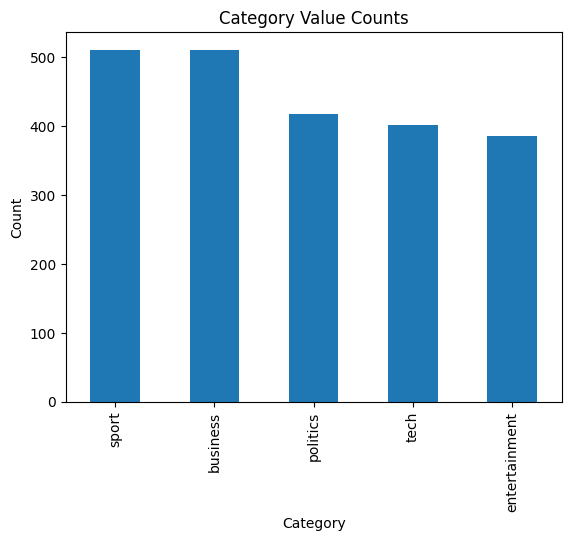

In [78]:
import matplotlib.pyplot as plt

category_distribution.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Value Counts')

plt.show()

In [79]:
import re
import nltk
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk import download
from nltk.stem import WordNetLemmatizer

download('wordnet')

lemmatizer = WordNetLemmatizer()

def clean_text(text):
    #remove HTML tags and lowercase the text
    text = re.sub(r'<.*?>', '', text).lower()
    #remove non-word characters
    text = re.sub(r'[^\w\s]', '', text)
    
    #tokenize the text
    tokens = simple_preprocess(text)
    #lemmatize the tokens and remove stop words
    lemmatized_text = [lemmatizer.lemmatize(token) for token in tokens if token not in STOPWORDS]
    return lemmatized_text

#create new column in dataframe with cleaned text
df['processed_text'] = df['content'].apply(clean_text)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nekot\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [80]:
df.head()

,category,filename,title,content,processed_text
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[quarterly, profit, medium, giant, timewarner,..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[dollar, hit, highest, level, euro, month, fed..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[owner, embattled, russian, oil, giant, yukos,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[british, airway, blamed, high, fuel, price, d..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[share, uk, drink, food, firm, allied, domecq,..."


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = stopwords.words('english')

X = df['processed_text'].astype(str)
y = df['category']

#split the dataset into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

#vectorize the content - remove stop words
vectorizer = TfidfVectorizer(stop_words=stop_words)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#build the logistic regression model with 1000 iterations and fit it to the training sets
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nekot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


LogisticRegression(max_iter=1000)

In [89]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

report = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred))


Accuracy: 0.9551
               precision    recall  f1-score   support

     business       0.97      0.92      0.95       172
entertainment       0.96      0.97      0.97       113
     politics       0.92      0.96      0.94       115
        sport       0.95      0.99      0.97       140
         tech       0.98      0.94      0.96       128

     accuracy                           0.96       668
    macro avg       0.95      0.96      0.96       668
 weighted avg       0.96      0.96      0.96       668



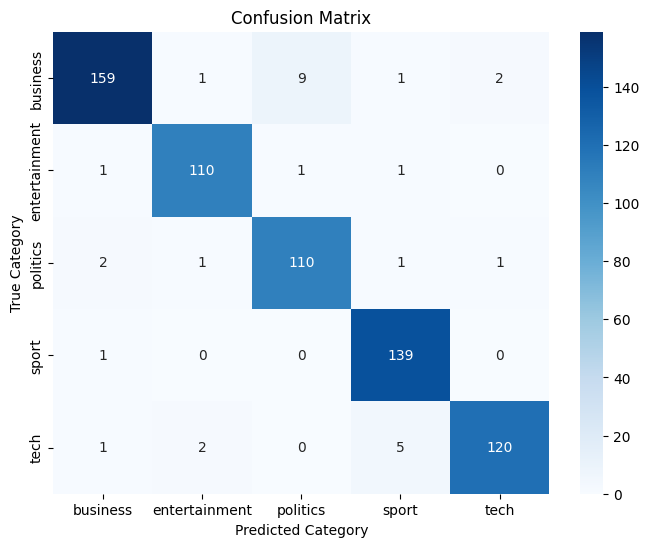

In [97]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#build the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#plot the matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('Confusion Matrix')
plt.show()
